In [1]:
!pip install tclab
%matplotlib inline
from tclab import clock, setup, Historian, Plotter
import pandas as pd

In [2]:
!pip install pHcalc
from pHcalc.pHcalc import Acid, Neutral, System
import numpy as np
import matplotlib.pyplot as plt # Optional for plotting below

In [3]:
def PID(Kp, Ki, Kd, MV_bar=0):
    # initialize stored data
    e_prev = 0
    t_prev = -100
    I = 0
    
    # initial control
    MV = MV_bar
    
    while True:
        # yield MV, wait for new t, PV, SP
        t, PV, SP = yield MV
        
        # PID calculations
        e = SP - PV
        
        P = Kp*e
        I = I + Ki*e*(t - t_prev)
        D = Kd*(e - e_prev)/(t - t_prev)
        
        MV = MV_bar + P + I + D
        
        # update stored data for next iteration
        e_prev = e
        t_prev = t

In [4]:
def pH(WasteFlow,pHreturn, LOUD = False):
    concH = 10^-(pHreturn)
    
    if pHreturn < 7:
        addbase = 7 - pHreturn
        addbaseConc = WasteFlow*addbase
        if LOUD:
            print('Must add: ', addbaseConc,' M of base at ', WasteFlow, 'L/h to neutralize waste flow')
    if pHreturn >7:
        addacid = pHreturn - 7
        addacidConc = WasteFlow*addacid
        if LOUD:
            print('Must add: ', addacidConc,' M of acid at ', WasteFlow, 'L/h to neutralize waste flow')
            
pH(10,5, LOUD = True)

Must add:  20  M of base at  10 L/h to neutralize waste flow


In [5]:
SP = 25
tfinal = 800

def proportional(Kp, SP):
    """Creates proportional controllers with specified gain and setpoint."""
    MV = 0
    while True:
        PV = yield MV
        MV = Kp * (SP - PV)

In [6]:
controller1 = proportional(10, 7)
controller1.send(None)

controller2 = proportional(1, 7)
controller2.send(None)

0

In [7]:
PV = 7.1

print("Controller 1: MV = ", controller1.send(PV))
print("Controller 2: MV = ", controller2.send(PV))

Controller 1: MV =  -0.9999999999999964
Controller 2: MV =  -0.09999999999999964


In [8]:
from scipy.optimize import least_squares

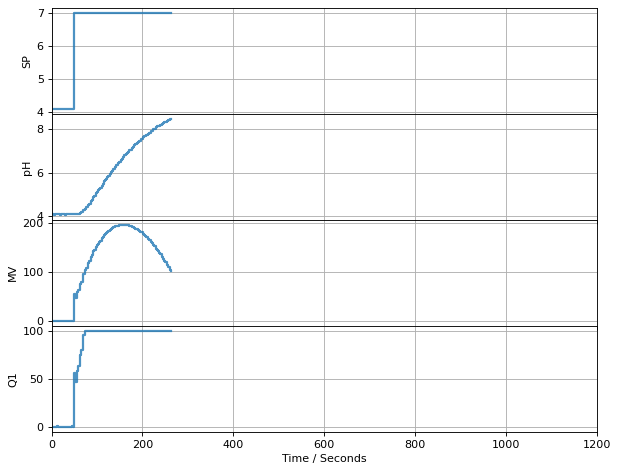

In [ ]:

%matplotlib inline
from tclab import clock, setup, Historian, Plotter

TCLab = setup(connected=False, speedup=20)

controller = PID(1, 0.1, 2)        # create pid control
controller.send(None)              # initialize

tfinal = 1200

SP = 21

with TCLab() as lab:
    SP = 21
    h = Historian([('SP', lambda: 2+ SP/10), ('pH', lambda: 2+ lab.T1/10), ('MV', lambda: MV), ('Q1', lab.Q1)])
    p = Plotter(h, tfinal)
    T1 = lab.T1
    for t in clock(tfinal, 2):
        SP = lab.T1 if t < 50 else 50           # get setpoint
        PV = lab.T1                         # get measurement
        MV = controller.send([t, PV, SP])   # compute manipulated variable
        lab.U1 = MV                         # apply 
        p.update(t)

    h.to_csv('PIDLab1.csv')

In [11]:
expt = pd.read_csv('PIDLab1.csv')
expt.index = expt['Time']

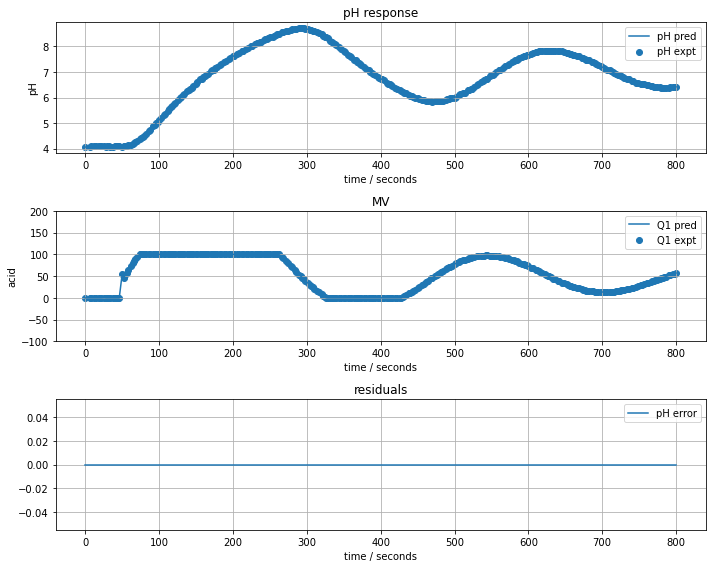

In [12]:
def plot_data(expt, pred):
    t_expt = expt.index
    
    # create a 3 x 1 grid of plot axes
    fig, ax = plt.subplots(3, 1, figsize=(10,8))
    
    # first plot axes
    ax[0].scatter(t_expt, expt["pH"], label="pH expt")
    ax[0].plot(t_expt, pred["pH"], label="pH pred")
    ax[0].set_ylabel("pH")
    ax[0].set_title("pH response")

    # second plot axes
    ax[1].scatter(t_expt, expt["Q1"], label="Q1 expt")
    ax[1].plot(t_expt, pred["Q1"], label="Q1 pred")
    ax[1].set_ylim([-100, 200])
    ax[1].set_ylabel("acid")
    ax[1].set_title("MV")
    
    # third plot axes
    ax[2].plot(t_expt, pred["pH"]-expt["pH"], label="pH error")
    ax[2].set_title("residuals")
    
    # things to do for every plot axes
    for a in ax:
        a.grid(True)
        a.set_xlabel("time / seconds")
        a.legend()
        
    plt.tight_layout()
    
    return
    
# demonstrate by comparing experimental data to itself
plot_data(expt, expt);

Time
0.00      0.037280
6.03      0.037280
8.01      0.005050
12.01     0.046965
14.01     0.088117
            ...   
790.00    0.848304
792.01    0.816306
796.02    0.816758
798.02    0.816979
800.00    0.817195
Name: pH, Length: 312, dtype: float64

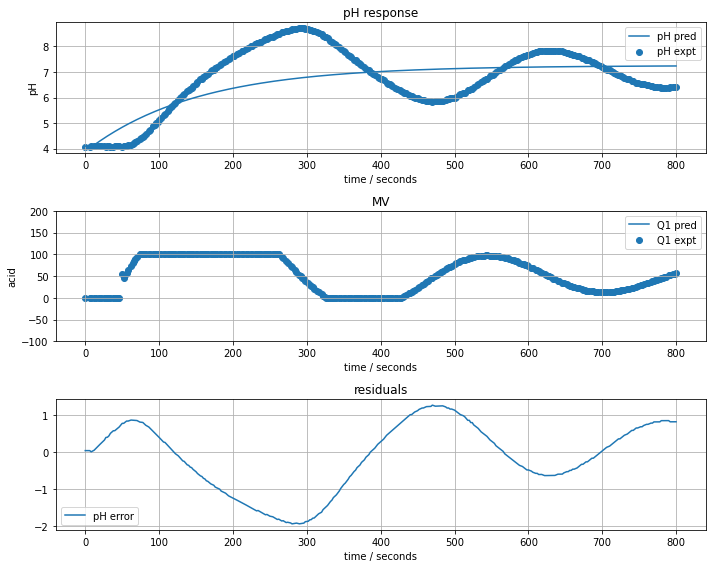

In [13]:
#LOOK AT LAB 4
# parameter values and units
pAmb = 21                 
u1bar = expt["Q1"].mean()
t_expt = expt.index

# adjustable parameters
K = 0.6
tau = 150
t_delay = 10

def model_first_order_delay(param, plot=False):
    K, tau, t_delay = param    
    pred = pd.DataFrame(columns=["pH","Q1"], index=t_expt)
    pred["pH"] = [2+(pAmb + K*u1bar*(1 - np.exp(-(t-t_delay)/tau)))/10 if t > t_delay else 2+pAmb/10 for t in t_expt]
    if plot:
        plot_data(expt, pred)
    return pred["pH"] - expt["pH"]
    
model_first_order_delay([K, tau, t_delay], True)

# Ziegler-Nichols

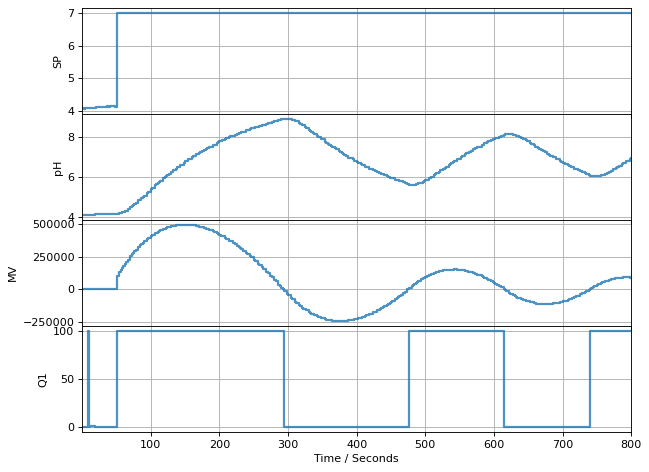

TCLab Model disconnected successfully.


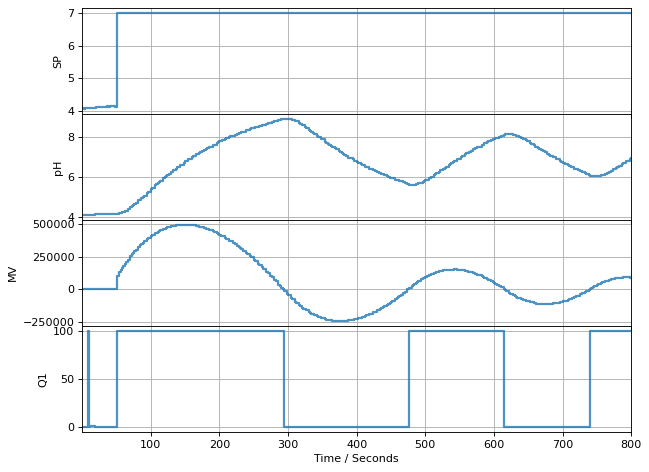

In [17]:
# Ziegler- Nichols

def PID_params(params):
    K, T, tau = params
    Kp = 1.2*(T/K*tau)
    Ki = 2*tau
    Kd = 0.5*tau

    return Kp, Ki, Kd

Kp, Ki, Kd = PID_params((K, t_delay, tau))
print(Kp, Ki, Kd)


controller = PID(Kp, Ki, Kd)        # create pid control
controller.send(None)              # initialize

tfinal = 1200

SP = 21

with TCLab() as lab:
    SP = 21
    h = Historian([('SP', lambda: 2+ SP/10), ('pH', lambda: 2+ lab.T1/10), ('MV', lambda: MV), ('Q1', lab.Q1)])
    p = Plotter(h, tfinal)
    T1 = lab.T1
    for t in clock(tfinal, 2):
        SP = lab.T1 if t < 50 else 50           # get setpoint
        PV = lab.T1                         # get measurement
        MV = controller.send([t, PV, SP])   # compute manipulated variable
        lab.U1 = MV                         # apply 
        p.update(t)

    h.to_csv('PIDLab2.csv')

# Relay Tuning

In [19]:
# Relay
def relay(SP, a = 5):
    MV = 0
    while True:
        PV = yield MV
        MV_prev = MV
        MV = 100 if PV < SP - a else 0 if PV > SP + a else MV_prev

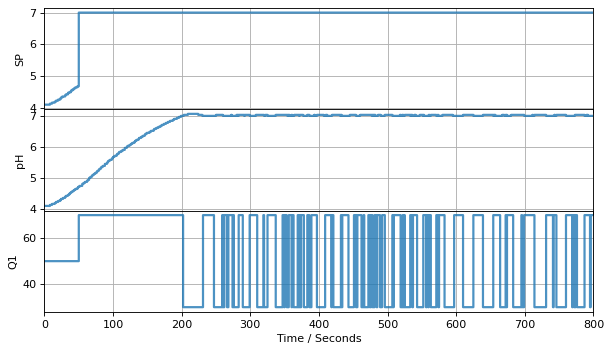

TCLab Model disconnected successfully.


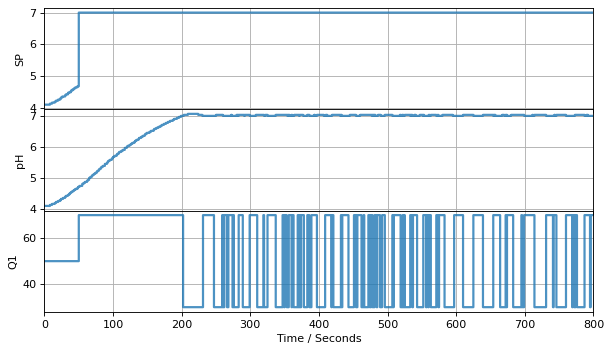

In [23]:
%matplotlib inline
from tclab import clock, setup, Historian, Plotter

TCLab = setup(connected=False, speedup=20)

tfinal = 800
MV_bar = 50
hMV = 20


SP = 21

with TCLab() as lab:
    h = Historian([('SP', lambda: 2+ SP/10), ('pH', lambda: 2+lab.T1/10), ('Q1', lab.Q1)])
    p = Plotter(h, tfinal)
    T1 = lab.T1
    for t in clock(tfinal, 1):
        if t < 50:
            SP = lab.T1
            MV = MV_bar
            
        else:
            SP = 50
            MV = (MV_bar - hMV) if (lab.T1 > SP) else (MV_bar + hMV)
        lab.Q1(MV)
        p.update(t)                                   # update information display
        h.to_csv('PIDLab4.csv')

# Cohen-Coons

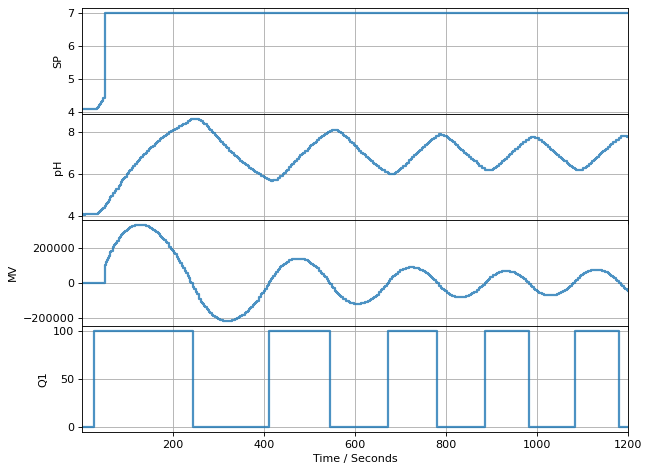

TCLab Model disconnected successfully.


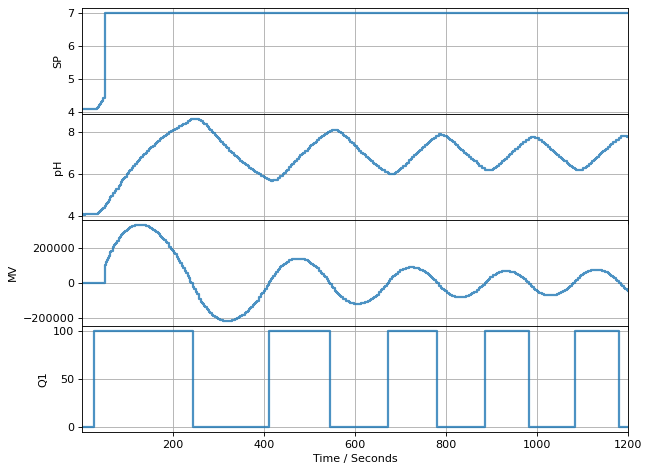

In [25]:
def PID_paramsCC(params):
    K, T, tau = params
    Kp = (T/K*tau)*(1.33+((tau/T)/4))
    Ki = (tau*(30+(3*(tau/T))))/(9+(20*(tau/T)))
    Kd = (4*tau)/(11+(2*(tau/T)))

    return Kp, Ki, Kd

Kp, Ki, Kd = PID_params((K, t_delay, tau))
print(Kp, Ki, Kd)


controller = PID(Kp, Ki, Kd)        # create pid control
controller.send(None)              # initialize

tfinal = 1200

SP = 21

with TCLab() as lab:
    SP = 21
    h = Historian([('SP', lambda: 2+ SP/10), ('pH', lambda: 2+ lab.T1/10), ('MV', lambda: MV), ('Q1', lab.Q1)])
    p = Plotter(h, tfinal)
    T1 = lab.T1
    for t in clock(tfinal, 2):
        SP = lab.T1 if t < 50 else 50           # get setpoint
        PV = lab.T1                         # get measurement
        MV = controller.send([t, PV, SP])   # compute manipulated variable
        lab.U1 = MV                         # apply 
        p.update(t)

    h.to_csv('PIDLab3.csv')